# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import random


## From here it's workable

In [2]:
def assign_scores(row):
    if row['booking_bool'] == 1:
        return 5
    elif row['click_bool'] == 1:
        return 1
    else:
        return 0

In [3]:
# 逐个读取feature_engineered_training_chunk{i}并上下拼接到一个df
base_path = '/Users/eva/Documents/Study/Y1S2/DMT/assignment2/'
file_pattern = 'feature_engineered_training_chunk_{}.csv'
for i in range(10):
    df_chunk = pd.read_csv(base_path + file_pattern.format(i))
    df_chunk['score'] = df_chunk.apply(assign_scores, axis=1)
    if i == 0:
        df = df_chunk
    else:
        df = pd.concat([df, df_chunk], axis=0)
df.head()


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,prop_location_score1_diff,prop_location_score2_diff,prop_review_score_diff,prop_starrating_diff,price_per_adult,price_per_person,prop_historical_price,prop_clicked_prob,child_bool,score
0,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,893,3,3.5,...,0.0,0.0,0.0,0.0,26.1925,26.1925,141.174964,0.0,False,0
1,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,10404,4,4.0,...,0.0,0.0,0.0,0.0,42.6850,42.6850,152.933013,0.0,False,0
2,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,21315,3,4.5,...,0.0,0.0,0.0,0.0,44.9500,44.9500,137.002613,0.0,False,0
3,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,27348,2,4.0,...,0.0,0.0,0.0,0.0,121.2100,121.2100,80.640419,0.0,False,0
4,1,2013-04-04 08:32:15,12,187,0.0,0.0,219,29604,4,3.5,...,0.0,0.0,0.0,0.0,35.8950,35.8950,138.379512,0.0,False,0


In [4]:
# 检查df NA 展示有NA的列
na_counts = df.isna().sum()

# 打印有NA值的列和NA值的数量
print("Columns with NA values and their counts:")
for col, count in na_counts.items():
    if count > 0:
        print(f"{col}: {count}")



Columns with NA values and their counts:


In [4]:
A = ['srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count']
B = ['_srch_destination_id_', 'srch_id']
C = ['median', 'mean', 'std']

columns_to_drop = [b + c for c in C for b in B]
print("Columns to drop:", columns_to_drop)
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


Columns to drop: ['_srch_destination_id_median', 'srch_idmedian', '_srch_destination_id_mean', 'srch_idmean', '_srch_destination_id_std', 'srch_idstd']


In [10]:
df_feature = pd.read_csv('feature_importance.csv')

# 筛选出Importance为0的特征
zero_importance_features = df_feature[df_feature['Importance'] == 0]['Feature'].tolist()


# 从原始数据集中删除这些特征
df.drop(columns=zero_importance_features, inplace=True)


In [5]:
columns = df.columns

# 使用列表推导式筛选出不需要删除的列
features = [
    col for col in columns if col not in ['date_time', 'position', 'click_bool', 'booking_bool', 'score', 'srch_id']
    and 'gross_bookings_usd' not in col and 'position' not in col
]



print(len(features))
print(len(df.columns))

212
219


In [8]:
print(features)

['srch_id', 'site_id', 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score', 'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv', 'comp8_rate_percent_diff', 'bool_visitor_hist', 'visitor_his

### Default Params

In [6]:
default_params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'max_depth': 3,
    'num_leaves': 28,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'min_child_samples': 40,
    'min_child_weight': 0.001,
    'bagging_fraction': 1,
    'bagging_freq': 2,
    'reg_alpha': 0.001,
    'reg_lambda': 8,
    'cat_smooth': 0,
    'num_iterations': 800,
    'is_unbalance': True  # 仅当你确信数据不平衡严重且影响模型性能时才设置
}

### Hyperparameter Tuning

In [21]:
unique_ids = df['srch_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42, shuffle=True)  # 首先分割出20%为最终测试集
train_val_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42, shuffle=True)  # 将剩余80%分为训练集(60%)和验证集(20%)

train_df = df[df['srch_id'].isin(train_val_ids)]
val_df = df[df['srch_id'].isin(val_ids)]
test_df = df[df['srch_id'].isin(test_ids)]

train_data = lgb.Dataset(train_df[features], label=train_df['score'], group=train_df['srch_id'].value_counts().sort_index())
val_data = lgb.Dataset(val_df[features], label=val_df['score'], group=val_df['srch_id'].value_counts().sort_index())
test_data = lgb.Dataset(test_df[features], label=test_df['score'], group=test_df['srch_id'].value_counts().sort_index())

In [9]:
param_grid = {
    'num_leaves': [180], 'max_depth': [13], 'min_child_samples': [220], 'learning_rate': [0.1], 'feature_fraction': [0.9], 
    'bagging_fraction': [0.96], 'bagging_freq': [3], 'reg_alpha': [5], 'reg_lambda': [150], 'num_iterations': [600], 
}

# random search
best_ndcg = 0
best_params = None
n_iterations = 50  # iterations for random search



for _ in range(n_iterations):
    random_params = {k: random.choice(v) for k, v in param_grid.items()}
    random_params.update({'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [5], 'verbose': -1, 
                          'boosting_type': 'gbdt', 'feature_pre_filter': False})
    print(random_params)
    bst = lgb.train(
        random_params,
        train_data,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(30)]
    )

    test_pred = bst.predict(test_df[features], num_iteration=bst.best_iteration)
    test_df['predictions'] = test_pred
    test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)
    grouped = test_df.groupby('srch_id')
    ndcg_scores = []

    for name, group in grouped:
        true_relevance = group['score'].values
        scores_pred = group['predictions'].values
        if len(np.unique(true_relevance)) > 1:
            ndcg_scores.append(ndcg_score([true_relevance], [scores_pred], k=5))

    average_ndcg = np.mean(ndcg_scores)
    print(f"Average NDCG Score: {average_ndcg}")
    if average_ndcg > best_ndcg:
        best_ndcg = average_ndcg
        best_params = random_params

print(f"Best NDCG Score: {best_ndcg}")
print("Best Parameters:", best_params)

{'num_leaves': 180, 'max_depth': 13, 'min_child_samples': 220, 'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_fraction': 0.96, 'bagging_freq': 3, 'reg_alpha': 5, 'reg_lambda': 150, 'num_iterations': 600, 'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [5], 'verbose': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False}


NameError: name 'val_data' is not defined

### Validation Result Documentation

1. params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [3, 5],
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': 3,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'min_child_samples': 40,
    'min_child_weight': 0.001,
    'bagging_fraction': 1,
    'bagging_freq': 2,
    'reg_alpha': 0.001,
    'reg_lambda': 8,
    'num_iterations': 200,
} 
    0.7177144351777821
2. params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [3, 5],
    'learning_rate': 0.1,
    'num_leaves': 20,
    'verbose': -1,
    'max_depth': 4,
    'learning_rate': 0.1,
    'min_child_samples': 40,
    'min_child_weight': 0.001,
    'bagging_fraction': 1,
    'bagging_freq': 2,
    'reg_alpha': 0.001,
    'reg_lambda': 8,
    'num_iterations': 200,
    'boosting_type': 'gbdt'
}0.7216631446757388
3. params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [3, 5],
    'learning_rate': 0.1,
    'num_leaves': 25,
    'verbose': -1,
    'max_depth': 5,
    'learning_rate': 0.1,
    'min_child_samples': 30,
    'min_child_weight': 0.001,
    'bagging_fraction': 1,
    'bagging_freq': 2,
    'reg_alpha': 0.001,
    'reg_lambda': 8,
    'num_iterations': 200,
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8
}Average NDCG Score: 0.6297555975271502

### Final model

/Users/eva/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


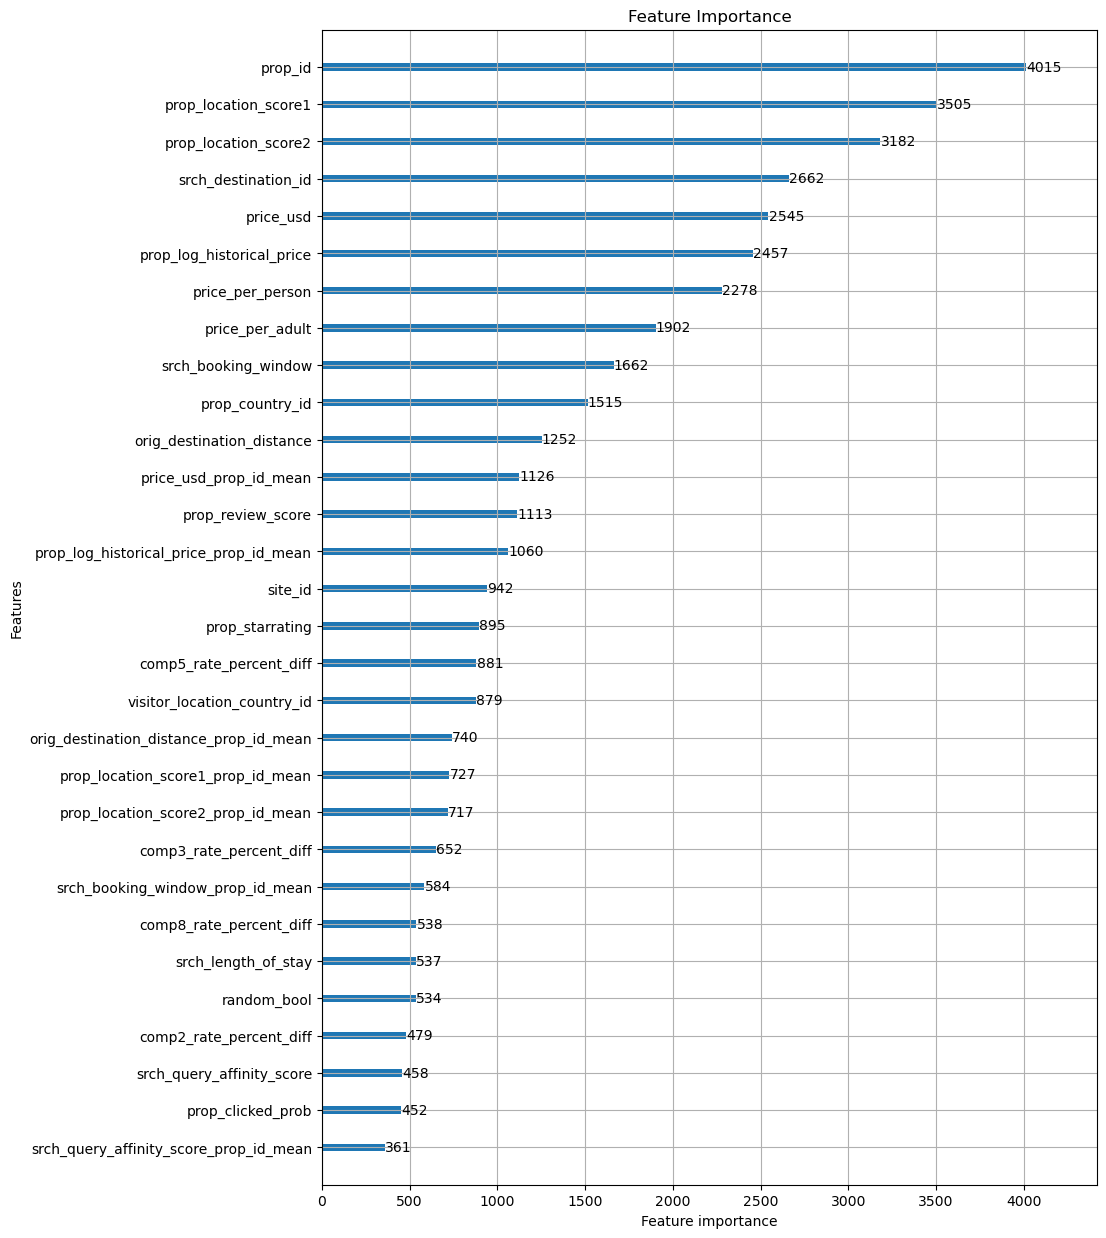

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_12426/2520211692.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predictions'] = test_pred
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_12426/2520211692.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)


Average NDCG Score: 0.3875707882714956


In [8]:
unique_ids = df['srch_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42, shuffle=True)
train_df = df[df['srch_id'].isin(train_ids)]
test_df = df[df['srch_id'].isin(test_ids)]


# 准备 LightGBM 数据结构
train_data = lgb.Dataset(train_df[features], label=train_df['score'], group=train_df['srch_id'].value_counts().sort_index())
test_data = lgb.Dataset(test_df[features], label=test_df['score'], group=test_df['srch_id'].value_counts().sort_index())

# 设置模型参数
params = {'num_leaves': 80, 'max_depth': 1, 'min_child_samples': 100, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'reg_alpha': 0.5, 'reg_lambda': 50, 'num_iterations': 600, 'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [5], 'verbose': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False}

# 训练模型
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

lgb.plot_importance(bst, max_num_features=30, importance_type='split', figsize=(10, 15), title='Feature Importance')
plt.show()
# 预测测试集
test_pred = bst.predict(test_df[features])

# 评估模型，计算 NDCG 分数
test_df['predictions'] = test_pred

# 首先确保数据按照 srch_id 和 predictions 降序排序
test_df.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# 分组并计算每个搜索会话的 NDCG
grouped = test_df.groupby('srch_id')
ndcg_scores = []

for name, group in grouped:
    group = group.sort_values('predictions', ascending=False)
    true_relevance = group['score'].values
    scores_pred = group['predictions'].values
    # 计算当前搜索会话的 NDCG 分数，并追加到列表中
    if len(np.unique(true_relevance)) > 1:  # 只计算有正样本的会话
        ndcg_scores.append(ndcg_score([true_relevance], [scores_pred], k=5))

average_ndcg = np.mean(ndcg_scores)
print(f"Average NDCG Score: {average_ndcg}")


In [9]:
importance = bst.feature_importance(importance_type='split')
feature_names = bst.feature_name()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 保存到CSV文件
feature_importance_df.to_csv('feature_importance2.csv', index=False)

print(feature_importance_df)

                                  Feature  Importance
5                                 prop_id        9679
9                    prop_location_score1        8418
10                   prop_location_score2        7591
14                    srch_destination_id        6945
193                      price_per_person        5311
..                                    ...         ...
69            prop_starrating_prop_id_std           0
120     price_usd_srch_destination_id_std           0
119  price_usd_srch_destination_id_median           0
117                 price_usd_srch_id_std           0
196                            child_bool           0

[197 rows x 2 columns]


### Result output

In [22]:
# 使用迭代器逐块读取数据
chunk_size = 10000
reader = pd.read_csv('/Users/eva/Documents/Study/Y1S2/DMT/assignment2/feature_engineered_test_set_VU_DM.csv', chunksize=chunk_size)

predictions = []  # 创建一个空列表以存储每个块的预测结果
for chunk in reader:
    # 可以在这里添加数据预处理步骤，比如填充缺失值等
    chunk_pred = bst.predict(chunk[features])  # 应用模型进行预测
    chunk['predictions'] = chunk_pred  # 将预测结果添加到 DataFrame
    predictions.append(chunk[['srch_id', 'prop_id', 'predictions']])  # 仅保留需要的列

# 合并所有批次的预测结果
final_predictions = pd.concat(predictions)

In [23]:
# 确保按照预测分数排序，如果 Kaggle 要求
final_predictions.sort_values(['srch_id', 'predictions'], ascending=[True, False], inplace=True)

# 选择需要的列
final_predictions = final_predictions[['srch_id', 'prop_id']]

# 保存为 CSV 文件，确保不包含索引，包含列标题
final_predictions.to_csv('train=all_featured_cleaned(train+set_all_grouped_by).csv', index=False, header=True)

In [24]:
print(final_predictions)

         srch_id  prop_id
23             1    99484
12             1    61934
9              1    54937
5              1    28181
20             1    90385
...          ...      ...
4959177   332787    29018
4959182   332787    99509
4959181   332787    94437
4959178   332787    32019
4959180   332787    35240

[4959183 rows x 2 columns]
